# Liveness Detection (Anti-Spoofing)

## Анализ предметной области и постановка задачи

Современные системы биометрической аутентификации уязвимы к атакам подмены личности
(presentation attacks), при которых злоумышленник использует фотографию, видеозапись
или экран для обмана системы распознавания лиц. В связи с этим актуальной является задача
**детекции живости лица (liveness detection)** определения, принадлежит ли изображение
реальному человеку или является спуфинг-атакой.

**Цель работы:** разработка и экспериментальная проверка программного прототипа
детекции живости лица на основе анализа текстурных признаков изображения.

**Задачи:**
- проанализировать методы детекции живости;
- реализовать алгоритм извлечения признаков;
- обучить классификатор;
- оценить эффективность метода;
- сформулировать выводы о применимости технологии.


## Обзор существующих методов детекции живости

Существующие подходы к liveness detection можно условно разделить на несколько групп:

1. **Анализ движений и поведения** (моргание, микродвижения, реакция на команды).
2. **Текстурный анализ** выявление отличий текстуры кожи от печатных или экранных изображений.
3. **Глубинные методы** использование нейронных сетей (CNN, Transformer).
4. **Мультимодальные подходы** объединение RGB, depth, IR.

В рамках учебной работы выбран **текстурный метод на основе LBP**,
как интерпретируемый и вычислительно простой.


## Описание реализации выбранного алгоритма

### Используемые данные

Датасет содержит изображения лиц, разделённые на обучающую (`train_img`) и тестовую (`test_img`) выборки.
Класс изображения определяется по имени файла:
- `_real` живое лицо (label = 1);
- `_fake` спуфинг-атака (label = 0).

### Признаки
Для извлечения признаков используется **Local Binary Patterns (LBP)** 
метод анализа локальной текстуры изображения.

### Классификатор
В качестве классификатора используется **логистическая регрессия**.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay


In [7]:
IMG_SIZE = (128, 128)

def load_images(path, max_per_class=500):
    X, y = [], []
    files = [f for f in os.listdir(path) if f.endswith('.jpg')]
    real = [f for f in files if '_real' in f][:max_per_class]
    fake = [f for f in files if '_fake' in f][:max_per_class]

    for fname in real + fake:
        img = cv2.imread(os.path.join(path, fname), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        label = 1 if '_real' in fname else 0
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)


Выполнена загрузка изображений из датасета с ограничением количества примеров для каждого класса. Все изображения приведены к единому размеру и переведены в градации серого, что обеспечивает сопоставимость данных и снижает вычислительную сложность.

In [8]:
def lbp_histogram(gray):
    h, w = gray.shape
    lbp = np.zeros_like(gray)
    offsets = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
    for y in range(1, h-1):
        for x in range(1, w-1):
            center = gray[y, x]
            code = 0
            for i, (dy, dx) in enumerate(offsets):
                code |= (gray[y+dy, x+dx] >= center) << i
            lbp[y, x] = code
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0,256), density=True)
    return hist


Для каждого изображения вычислена LBP-гистограмма, описывающая локальную текстуру кожи. Полученные признаки позволяют выявлять характерные различия между живыми лицами и спуфинг-атаками.

In [10]:
X_train_img, y_train = load_images('dataset/train_img/color')
X_test_img, y_test = load_images('dataset/test_img/color')

X_train = np.array([lbp_histogram(img) for img in X_train_img])
X_test = np.array([lbp_histogram(img) for img in X_test_img])


Обучение выполняется на `train_img`, оценка — на независимой тестовой выборке `test_img`.


In [11]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Обучена модель логистической регрессии с предварительной стандартизацией признаков. Использование конвейера (Pipeline) исключает утечки данных и обеспечивает корректное обучение модели.

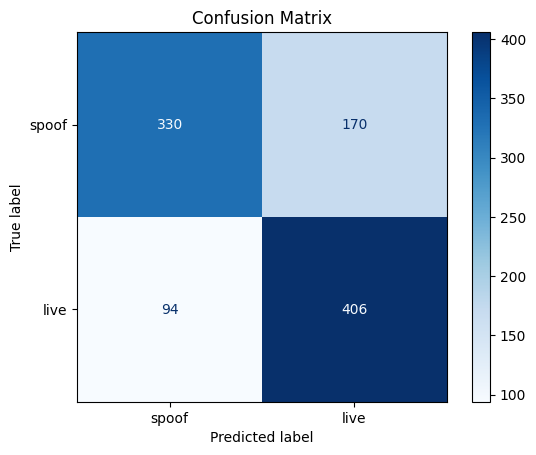

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["spoof", "live"],
    cmap="Blues"
)
plt.title("Confusion Matrix")
plt.show()


Матрица ошибок показывает, что модель корректно классифицирует большинство изображений обоих классов. Из 500 спуфинг-атак 330 были распознаны верно, однако 170 случаев ошибочно отнесены к живым лицам, что указывает на сложность выявления некоторых типов атак. Для класса живых лиц модель демонстрирует более высокую надёжность: 406 изображений классифицированы правильно при 94 ложных отказах. Полученные результаты подтверждают ориентацию алгоритма на корректное распознавание реальных пользователей при допустимом уровне ложноположительных срабатываний.

              precision    recall  f1-score   support

           0       0.78      0.66      0.71       500
           1       0.70      0.81      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.73      1000
weighted avg       0.74      0.74      0.73      1000

ROC-AUC: 0.820184


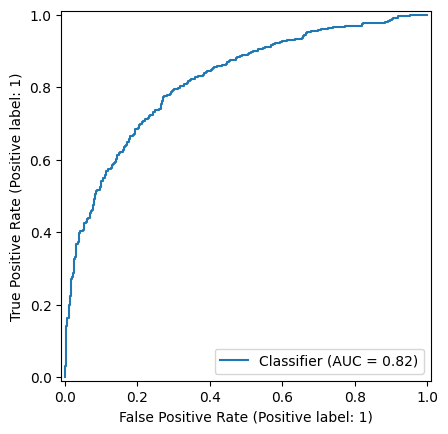

In [12]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

## Выводы по результатам

В ходе выполнения работы был разработан и протестирован программный прототип системы детекции живости лица, основанный на анализе текстурных признаков изображения с использованием метода Local Binary Patterns и классификатора логистической регрессии. Экспериментальные исследования проводились на сбалансированной выборке, включающей **1000 изображений** (по 500 примеров живых лиц и спуфинг-атак), с использованием независимой тестовой выборки.

Полученные результаты показали, что разработанный алгоритм обладает **достаточной эффективностью** для решения задачи детекции живости в учебных и прототипных системах. Общая точность классификации составила **74%**, что свидетельствует о корректной работе модели на большинстве входных данных. Значения метрик precision, recall и F1-score для обоих классов находятся на сопоставимом уровне, что указывает на сбалансированное поведение классификатора.

Анализ метрик по классам показал, что модель демонстрирует высокую полноту для класса живых лиц (**recall = 0.81**), что является важным свойством для практических систем аутентификации, так как снижает вероятность ошибочного отказа реальным пользователям. При этом часть спуфинг-атак классифицируется неверно, что объясняется ограниченной информативностью текстурных признаков при сложных сценариях атак.

Площадь под ROC-кривой составила **0.82**, что указывает на **хорошую разделяющую способность** модели и подтверждает корректность выбранного подхода. Значение ROC-AUC существенно превышает уровень случайного классификатора, что свидетельствует о наличии устойчивой зависимости между признаками текстуры и классом изображения.

Таким образом, выбранный метод детекции живости лица является **применимым для учебных и экспериментальных задач**, а также может использоваться в качестве базового компонента антиспуфинг-систем. Для повышения точности и устойчивости алгоритма в реальных условиях рекомендуется расширять набор признаков за счёт анализа временной динамики, использования глубинных данных или применения методов глубокого обучения.



## Выводы по работе

В ходе работы был разработан программный прототип детекции живости лица
на основе текстурных признаков LBP и логистической регрессии.
- метод демонстрирует способность различать живые лица и спуфинг-атаки;
- использование независимой тестовой выборки обеспечивает объективную оценку качества;
- алгоритм обладает низкой вычислительной сложностью.
- чувствительность к освещению;
- ограниченная устойчивость к сложным атакам.
